# Adaptive grid sampler tutorial 
### August George, Zuckerman Lab, OHSU, 2023

This method iterates through an increasing data batch size until all the data is included (i.e. 'data tempering'). 

After initialization, an adaptive multi-grid approach is used to evaluate the log-likelihood surface.


We will use a a toy model to test the adaptive grid sampler (in `toy_model.py`):

$y=a\sin(bx)+ax\sin(bx^2)$ where $a=5$, $b=0.1$, and $t=0,0.05,...,5$ with Gaussian noise added: $y_{obs} = y_{true} + \epsilon$ where $\epsilon \sim N(0,1)$

We will also use a Normal log-likelihood function. 

Log-likelihood functions are expected to have the form f(x,args) where x = parameters, args = [data, additional arguments] 

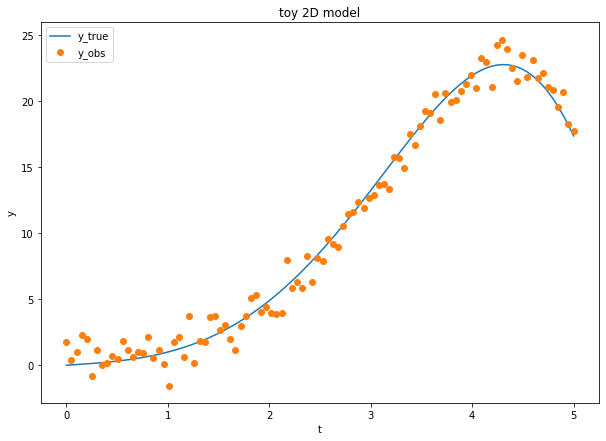

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from pyGridSampler import grid_sampler as gs
from pyGridSampler import grid_tools as gt
import toy_model  # seperate file containing log-likelihood and model functions


# setup toy model
np.random.seed(0)
x1_true = 5
x2_true = 0.1
sigma_true = 1
t_full = np.linspace(0, 5, 100)
x_truths = [x1_true, x2_true]

y_true = toy_model.f(x1_true,x2_true,t_full)
y_obs = y_true + np.random.normal(0,sigma_true,np.size(y_true))
log_like_func = toy_model.log_likelihood

# plot synthetic data
plt.figure(figsize=(10,7))
plt.plot(t_full, y_true, label='y_true')
plt.plot(t_full, y_obs, 'o', label='y_obs')
plt.title('toy 2D model')
plt.ylabel('y')
plt.xlabel('t')
plt.legend()
plt.show()

For the grid sampler using data-tempering (i.e. iterative batch sizes), we need to create a data tempering list of lists containing increasingly more data. 

Each iteration of the algorithm includes an additional data point - i.e. the next list in the data tempering list. 

For this example we increment the data, but other strategies could be used (e.g. first data point, last data point, mid point, etc)

Example: tempering_list = [[y1], [y1,y2], ... [y1,y2,...yN]]

Additional log-likelihood arguments can be packed into this list as well.

In [2]:
def create_tempering_list(log_like_args):
    # creates a list of arguments for the log-likelihood function at each tempering stage
    y_obs = log_like_args[0]
    t_full = log_like_args[1]
    n_data_points = len(y_obs)

    # get a list of data indices for data tempering - e.g. [[0], [0,1], [0,1,2]]
    # each list index corresponds to a data tempering stage
    idx_sublist = gt.get_sorted_idx_sublists(y_obs)

    # get y_obs and t lists for each data tempering stage
    # e.g. t_tempering_list = [t[0], t[0,1], t[0,1,2]]
    t_sublist = gt.get_sorted_sublists_from_idx(idx_sublist, t_full)
    y_obs_sublist = gt.get_sorted_sublists_from_idx(idx_sublist, y_obs)

    # at a given tempering stage n, this list contains data[:n], t[:n] for the log-likelihood calculation
    args_tempering_list = [[y_obs_sublist[i], t_sublist[i]] for i in range(n_data_points)]
    return args_tempering_list

args_list = create_tempering_list([y_obs, t_full])

Then we make a set of parameter boundaries and list of direction to add neighboring points during the expansion stage. 

For example, [[1,1],] would add a single point for each existing grid point in the (1,1) direction

Finally we set the initial conditions and hyperparameters for the sampler, and then run the sampler

In [3]:
# configure sampler parameters
x_bounds = [(0,10), (0,2)]
x_shifts = [[1,1], [-1,1], [1,-1], [-1,-1], [1,0], [-1,0], [0,1], [0,-1]]


init_data_size = 2 # use 2 data points initially
init_grid_resolution = 10 # n points per parameter -> total grid size =  n^n_dim points
ess_min = 500  # target effective size threshold. larger ess_min --> denser grid 
delta = 0.01 # keep smallest set of grid points whose weights sum to 1-delta. larger delta --> remove more gridpoints


# create sampler class
sampler = gs.GridSampler(log_like_func,args_list,y_obs, x_bounds, x_shifts)

# initialize and run sampler (parallelized across 4 processes)
grid_resolution, data_size, grid, spacing, log_likelihoods, rel_prob, weights, ess  = sampler.initialize_and_sample(init_grid_resolution, init_data_size, ess_min, delta, n_processes=4, max_iter=100, store_results=True)


Intialization: data_size=2, grid_resolution=23, n_grid_points=529, ESS=507.33340773401375, init_func_evals:4039: : 13it [00:02,  4.70it/s]
Processing: data_size=100, n_grid_points=4748, ESS=1276.0242986214855, func_evals:5639: 100%|██████████| 98/98 [09:07<00:00,  5.59s/it]


We can plot the grids for different batch sizes by accessing `sampler.grid_results` 

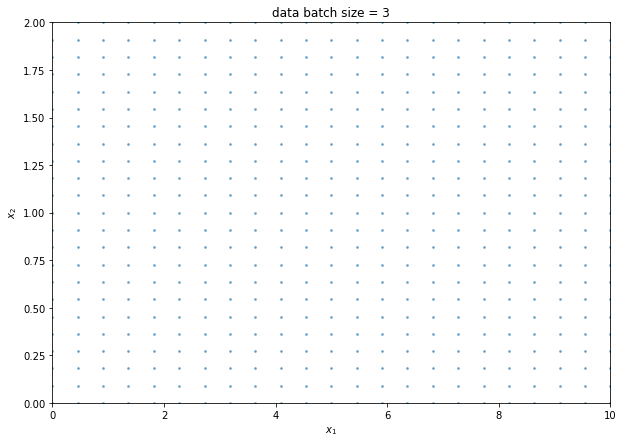

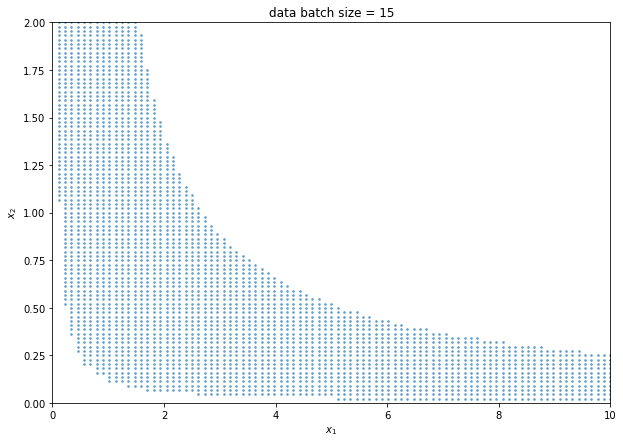

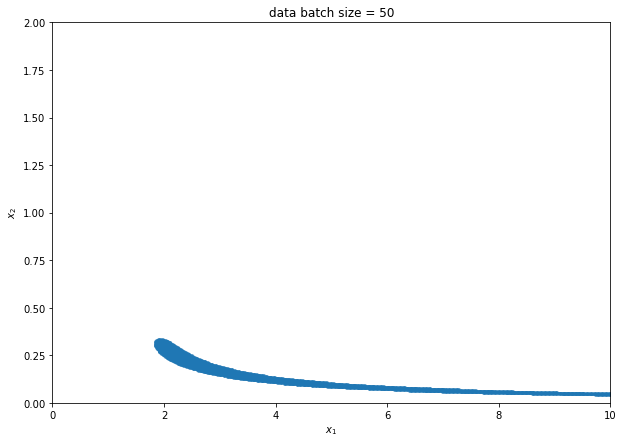

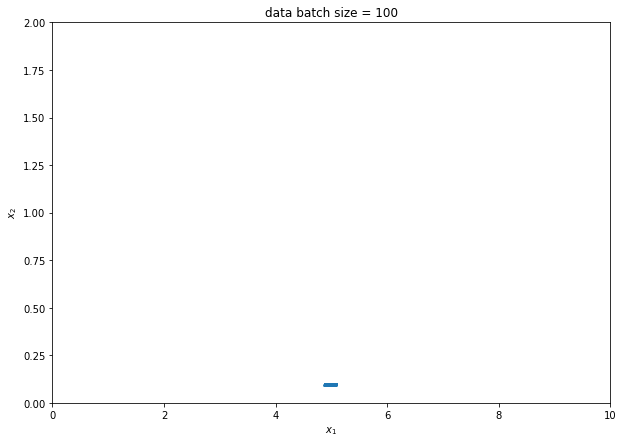

In [28]:
def plot_grid(grid_i, i):
    plt.figure(figsize=(10,7))
    x = grid_i[:, 0]
    y = grid_i[:, 1]
    plt.scatter(x, y, s=3, alpha=0.55)
    plt.xlim(x_bounds[0])
    plt.ylim(x_bounds[1])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.tight_layout
    plt.title(f'data batch size = {i+3}')

grid_results = sampler.grid_results

# plot first, quarter, middle, and last (full) data batch grids
for idx in [0, 12, 47, 97]:
    grid_i = grid_results[idx]
    plot_grid(grid_i, idx)

for comparison we can generate the brute force grid evaluation of the likelihood surface

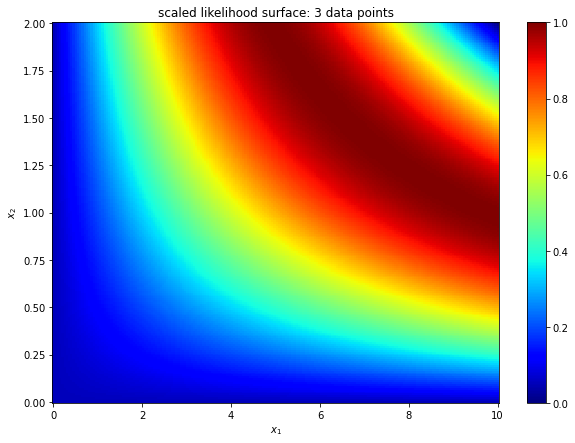

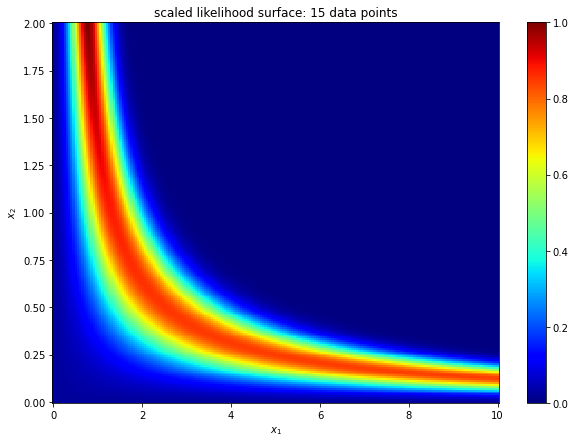

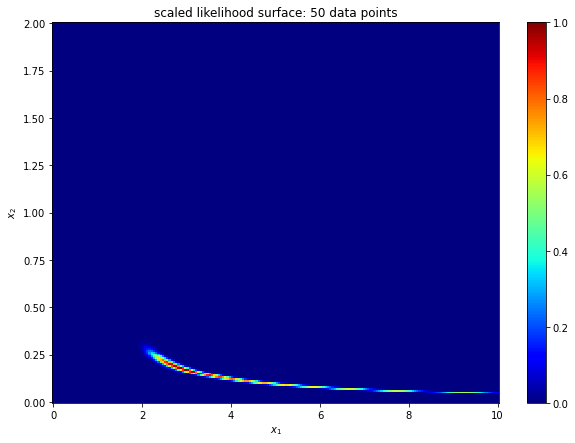

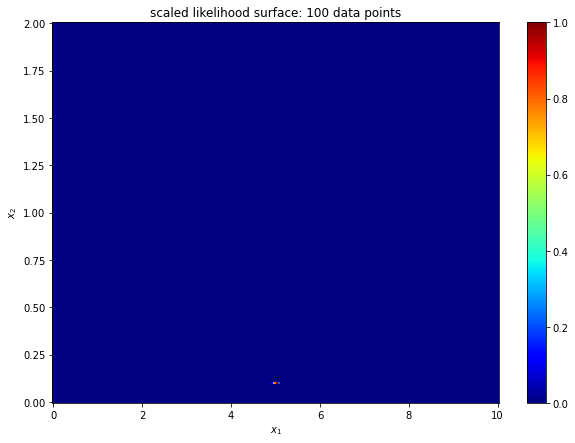

In [5]:
x1_vals = np.linspace(0, 10, 200)
x2_vals = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x1_vals, x2_vals)

for i in [3,15,50,100]:
    t_i = t_full[:i]
    y_obs_i = y_obs[:i]
    log_likelihood_grid = np.zeros((len(x1_vals), len(x2_vals)))
    for j, x1 in enumerate(x1_vals):
        for k, x2 in enumerate(x2_vals):
            params = [x1, x2]
            args = [y_obs_i, t_i]
            log_likelihood_grid[k, j] = toy_model.log_likelihood(params, args)

    log_likelihood_grid_scaled = (log_likelihood_grid - np.min(log_likelihood_grid)) / (np.max(log_likelihood_grid) - np.min(log_likelihood_grid))
    likelihood_grid = np.exp(log_likelihood_grid)
    likelihood_grid_scaled = (likelihood_grid - np.min(likelihood_grid))/np.ptp(likelihood_grid)

    # Create a heatmap of the scaled log-likelihood values
    plt.figure(figsize=(10,7))
    plt.pcolormesh(X, Y, likelihood_grid_scaled, cmap='jet')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(f'scaled likelihood surface: {np.size(y_obs_i)} data points')
    plt.colorbar()
    plt.show()

we can also compare the cumulative number of function evaluations (i.e. log-likelihood) for the adaptive grid method vs a naive grid based on the parameter spacing at each batch size.

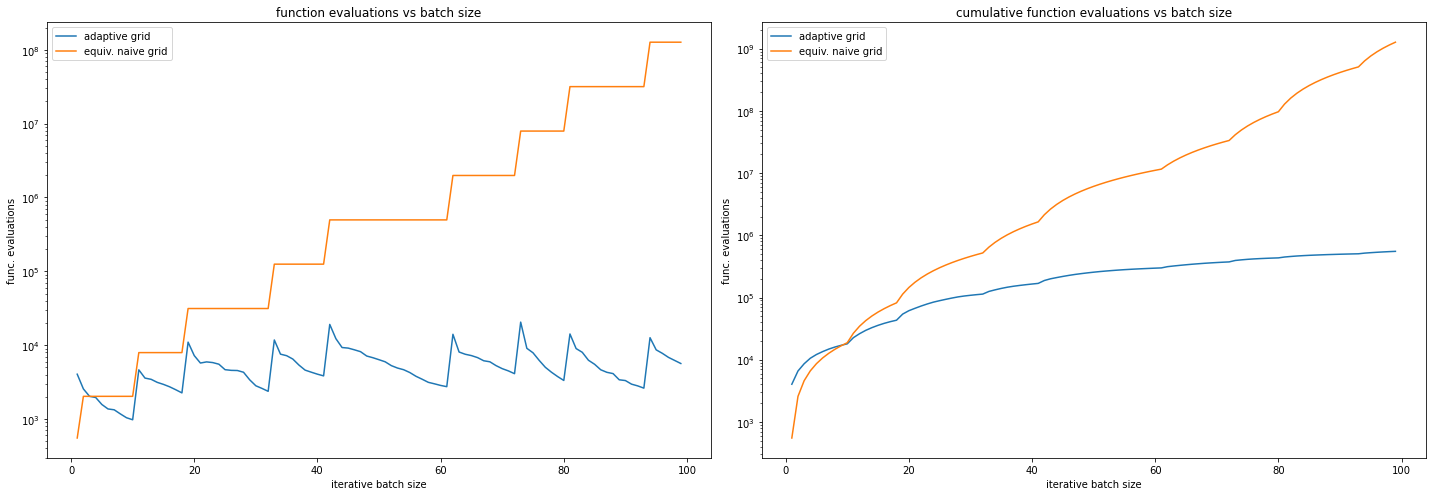

In [26]:
# get N naive mesh grid function evaluations based on grid spacing for that batch size
naive_grid_size = []
for x_spacing_i in sampler.x_spacing_results:
    x1_i = np.arange(x_bounds[0][0], x_spacing_i[0] + x_bounds[0][1],  x_spacing_i[0])
    x2_i = np.arange(x_bounds[1][0], x_spacing_i[1] + x_bounds[1][1],  x_spacing_i[1])
    grid_size = (np.size(x1_i)*np.size(x2_i))
    naive_grid_size.append(grid_size)

# get N grid function evaluations
f_evals = sampler.func_evals

# make subplot
y = f_evals
y2 = naive_grid_size
x = np.linspace(1,len(y),len(y))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
axs[0].plot(x,y, label='adaptive grid')
axs[0].plot(x,y2, label='equiv. naive grid')
axs[0].set_xlabel('iterative batch size')
axs[0].set_ylabel(f'func. evaluations')
axs[0].set_yscale('log')
axs[0].set_title('function evaluations vs batch size')
axs[0].legend()

axs[1].plot(x,np.cumsum(y), label='adaptive grid')
axs[1].plot(x,np.cumsum(y2), label='equiv. naive grid')
axs[1].set_xlabel('iterative batch size')
axs[1].set_ylabel(f'func. evaluations')
axs[1].set_yscale('log')
axs[1].set_title('cumulative function evaluations vs batch size')
axs[1].legend()
plt.tight_layout()
plt.show()


we can also compare the size of the adapative grid vs a naive grid based on the parameter spacing at each batch size.

the adaptive grid evaluates the high probability regions of the likelihood function, which is a small fraction of the total parameter space

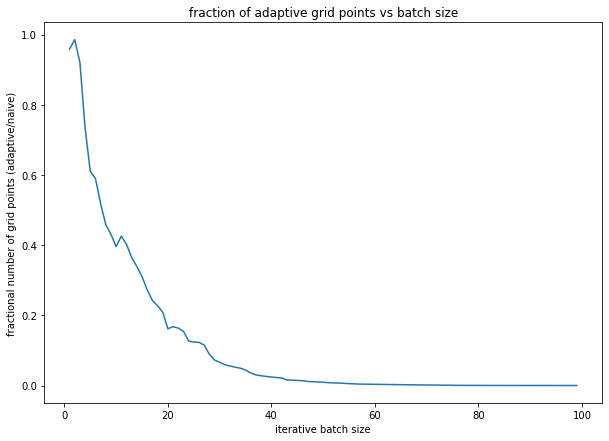

In [27]:
# get grid sizes 
adaptive_grid_sizes = np.array(sampler.grid_size)
frac_grid_size = adaptive_grid_sizes/np.array(naive_grid_size)

y = frac_grid_size
x = np.linspace(1,len(y),len(y))

plt.figure(figsize=(10,7))
plt.plot(x,y)
plt.xlabel('iterative batch size')
plt.ylabel(f'fractional number of grid points (adaptive/naive)')
plt.title(f'fraction of adaptive grid points vs batch size')
plt.show()